In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Definir fecha objetivo
fecha_objetivo = '2020-02-01'

# 3. Construir base de predicción: todos los customer_id + product_id posibles
df_pred = df[['product_id', 'customer_id']].drop_duplicates().copy()
df_pred['periodo'] = pd.to_datetime(fecha_objetivo)

# 4. Dataset histórico de entrenamiento
df_train = df[df['periodo'] < fecha_objetivo].copy()

# 5. Función para agregar features dinámicos de los últimos 12 meses
def agregar_features(df_base, df_hist, fecha_prediccion):
    inicio = pd.to_datetime(fecha_prediccion) - pd.DateOffset(months=12)
    fin = pd.to_datetime(fecha_prediccion) - pd.DateOffset(days=1)
    
    ultimos12 = df_hist[(df_hist['periodo'] >= inicio) & (df_hist['periodo'] <= fin)]
    
    feats = ultimos12.groupby(['customer_id', 'product_id'])['tn'].agg([
        'mean', 'median', 'max', 'min', 'std', 'sum'
    ]).reset_index()
    
    feats.columns = ['customer_id', 'product_id', 'tn_mean_12', 'tn_median_12',
                     'tn_max_12', 'tn_min_12', 'tn_std_12', 'tn_sum_12']
    
    df_final = df_base.merge(feats, on=['customer_id', 'product_id'], how='left')
    return df_final

# 6. Dataset de entrenamiento para evaluar (febrero 2019)
target_feb2019 = df[df['periodo'] == '2019-02-01'][['customer_id', 'product_id', 'tn']]
X_train_base = df[df['periodo'] < '2019-02-01']
X_train = agregar_features(target_feb2019, X_train_base, '2019-02-01')

# Eliminar filas sin historial (puede usarse fillna si se desea otro enfoque)
X_train = X_train.dropna(subset=['tn_mean_12'])
y_train = target_feb2019.merge(X_train[['customer_id', 'product_id']], on=['customer_id', 'product_id'])['tn']

# 7. Dataset de predicción para febrero 2020
X_pred = agregar_features(df_pred, df_train, '2020-02-01')

# 8. Entrenar LightGBM
features = [col for col in X_train.columns if col.startswith('tn_')]
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train[features], y_train)

# 9. Predecir
X_pred['tn_predicho_lgbm'] = model.predict(X_pred[features])

# 10. Baseline: promedio de febreros anteriores (2018 y 2019)
df_feb = df[df['periodo'].isin(['2018-02-01', '2019-02-01'])]
baseline = df_feb.groupby(['customer_id', 'product_id'])['tn'].mean().reset_index()
baseline.columns = ['customer_id', 'product_id', 'tn_predicho_baseline']

# 11. Comparar baseline vs LGBM
comparado = X_pred.merge(baseline, on=['customer_id', 'product_id'], how='left')

# 12. Agregado final por product_id (sólo predicción LGBM)
final = comparado.groupby('product_id')['tn_predicho_lgbm'].sum().reset_index()

# 13. Renombrar a formato Kaggle-friendly
final.rename(columns={'tn_predicho_lgbm': 'tn'}, inplace=True)

# 14. Exportar
final.to_csv("prediccion_febrero2020_final.csv", index=False)

print("✅ Archivo final listo: prediccion_febrero2020_final.csv con columnas: product_id, tn")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 262805, number of used features: 6
[LightGBM] [Info] Start training from score 0.103497


C:\Users\waldo\AppData\Local\Temp\ipykernel_26776\282419265.py:58: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_feb = df[df['periodo'].isin(['2018-02-01', '2019-02-01'])]


✅ Archivo final listo: prediccion_febrero2020_final.csv con columnas: product_id, tn


In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Fecha objetivo
fecha_objetivo = '2020-02-01'

# 3. Dataset de predicción base (todas las combinaciones customer-product)
df_pred = df[['product_id', 'customer_id']].drop_duplicates().copy()
df_pred['periodo'] = pd.to_datetime(fecha_objetivo)

# 4. Dataset histórico de entrenamiento
df_train = df[df['periodo'] < fecha_objetivo].copy()

# 5. Función para generar features
def agregar_features(df_base, df_hist, fecha_prediccion):
    inicio = pd.to_datetime(fecha_prediccion) - pd.DateOffset(months=12)
    fin = pd.to_datetime(fecha_prediccion) - pd.DateOffset(days=1)
    
    ultimos12 = df_hist[(df_hist['periodo'] >= inicio) & (df_hist['periodo'] <= fin)]
    
    feats = ultimos12.groupby(['customer_id', 'product_id'])['tn'].agg([
        'mean', 'median', 'max', 'min', 'std', 'sum'
    ]).reset_index()
    
    feats.columns = ['customer_id', 'product_id', 'tn_mean_12', 'tn_median_12',
                     'tn_max_12', 'tn_min_12', 'tn_std_12', 'tn_sum_12']
    
    df_base = df_base.merge(feats, on=['customer_id', 'product_id'], how='left')
    
    # Lags
    for lag in [1, 2, 3]:
        mes_lag = pd.to_datetime(fecha_prediccion) - pd.DateOffset(months=lag)
        df_lag = df_hist[df_hist['periodo'] == mes_lag][['customer_id', 'product_id', 'tn']]
        df_lag.rename(columns={'tn': f'lag_{lag}'}, inplace=True)
        df_base = df_base.merge(df_lag, on=['customer_id', 'product_id'], how='left')

    # Estacionalidad: promedio de febreros previos
    feb_anteriores = df_hist[df_hist['periodo'].dt.month == 2]
    feb_avg = feb_anteriores.groupby(['customer_id', 'product_id'])['tn'].mean().reset_index()
    feb_avg.rename(columns={'tn': 'tn_feb_avg'}, inplace=True)
    df_base = df_base.merge(feb_avg, on=['customer_id', 'product_id'], how='left')
    
    return df_base

# 6. Dataset de entrenamiento (para validación interna en feb 2019)
target_feb2019 = df[df['periodo'] == '2019-02-01'][['customer_id', 'product_id', 'tn']]
X_train_base = df[df['periodo'] < '2019-02-01']
X_train = agregar_features(target_feb2019.copy(), X_train_base, '2019-02-01')
X_train = X_train.dropna(subset=['tn_mean_12'])  # aseguramos historial

# Target y features
y_train = target_feb2019.merge(X_train[['customer_id', 'product_id']], on=['customer_id', 'product_id'])['tn']
features = [col for col in X_train.columns if col.startswith('tn_') or col.startswith('lag_')]

# 7. Dataset de predicción para febrero 2020
X_pred = agregar_features(df_pred.copy(), df_train, '2020-02-01')

# 8. Rellenar NaN con 0 (válido porque 0 es un valor real)
X_train[features] = X_train[features].fillna(0)
X_pred[features] = X_pred[features].fillna(0)

# 9. Entrenar modelo LightGBM
model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, num_leaves=20)
model.fit(X_train[features], y_train)

# 10. Predecir
X_pred['tn_predicho'] = model.predict(X_pred[features])

# 11. Agregar por product_id
final = X_pred.groupby('product_id')['tn_predicho'].sum().reset_index()
final.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 12. Exportar
final.to_csv("prediccion_mejorada_febrero2020.csv", index=False)

print("✅ Archivo final listo: prediccion_mejorada_febrero2020.csv")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 262805, number of used features: 10
[LightGBM] [Info] Start training from score 0.103497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas mensuales por product_id
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar lags
df_prod = df_prod.sort_values(['product_id', 'periodo'])
for lag in [1, 2, 3]:
    df_prod[f'lag_{lag}'] = df_prod.groupby('product_id')['tn'].shift(lag)

# 4. Calcular media de febreros anteriores (2018 y 2019)
df_febs = df_prod[df_prod['periodo'].dt.strftime('%Y-%m').isin(['2018-02', '2019-02'])]
feb_avg = df_febs.groupby('product_id')['tn'].mean().reset_index()
feb_avg.rename(columns={'tn': 'media_feb'}, inplace=True)

# 5. Dataset de entrenamiento: predecir febrero 2019
X_train = df_prod[df_prod['periodo'] == '2019-02-01'][['product_id', 'tn', 'lag_1', 'lag_2', 'lag_3']].copy()
X_train = X_train.merge(feb_avg, on='product_id', how='left')
X_train = X_train.dropna()  # aseguramos lags válidos
y_train = X_train['tn']
X_train = X_train.drop(columns=['tn'])

# 6. Dataset de predicción: febrero 2020
# Usamos todos los productos del dataset (no los de feb 2020)
X_pred = pd.DataFrame({'product_id': df['product_id'].unique()})

# Lags a enero 2020
lags_enero = df_prod[df_prod['periodo'] == '2020-01-01'][['product_id', 'lag_1', 'lag_2', 'lag_3']]
X_pred = X_pred.merge(lags_enero, on='product_id', how='left')

# Estacionalidad de febreros anteriores
X_pred = X_pred.merge(feb_avg, on='product_id', how='left')

# Rellenar NaN con 0 (válido porque 0 es venta posible)
X_pred.fillna(0, inplace=True)

# 7. Entrenar modelo LightGBM
features = ['lag_1', 'lag_2', 'lag_3', 'media_feb']
model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, num_leaves=15)
model.fit(X_train[features], y_train)

# 8. Predecir febrero 2020
X_pred['tn'] = model.predict(X_pred[features])

# 9. Exportar
X_pred[['product_id', 'tn']].to_csv("prediccion_producto_febrero2020.csv", index=False)
print("✅ Archivo generado: prediccion_producto_febrero2020.csv")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 4
[LightGBM] [Info] Start training from score 34.871354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [8]:
import pandas as pd
from scipy.stats import mode

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Base: todas las combinaciones customer-product a predecir
df_pred = df[['customer_id', 'product_id']].drop_duplicates().copy()

# 3. LAG 1: ventas en enero 2020
lag1 = df[df['periodo'] == '2020-01-01'][['customer_id', 'product_id', 'tn']]
lag1.rename(columns={'tn': 'lag_1'}, inplace=True)
df_pred = df_pred.merge(lag1, on=['customer_id', 'product_id'], how='left')

# 4. Moda de tn en últimos 12 meses por customer-product
ultimos12 = df[(df['periodo'] >= '2019-02-01') & (df['periodo'] <= '2020-01-31')]

def calcular_moda(grupo):
    vals = grupo['tn']
    if len(vals) == 0:
        return 0.0
    m = mode(vals, keepdims=False).mode
    return float(m) if hasattr(m, '__len__') else m

modas = ultimos12.groupby(['customer_id', 'product_id']).apply(calcular_moda).reset_index()
modas.columns = ['customer_id', 'product_id', 'moda_12m']
df_pred = df_pred.merge(modas, on=['customer_id', 'product_id'], how='left')

# 5. Media de febreros anteriores por producto
feb_anteriores = df[df['periodo'].dt.strftime('%Y-%m').isin(['2018-02', '2019-02'])]
media_feb = feb_anteriores.groupby('product_id')['tn'].mean().reset_index()
media_feb.rename(columns={'tn': 'media_feb'}, inplace=True)
df_pred = df_pred.merge(media_feb, on='product_id', how='left')

# 6. Rellenar NaN con 0 (válido)
df_pred.fillna(0, inplace=True)

# 7. Calcular predicción blend por customer-product
df_pred['tn_blend'] = (
    df_pred['lag_1'] * 0.4 +
    df_pred['moda_12m'] * 0.3 +
    df_pred['media_feb'] * 0.3
)

# 8. Agregar por product_id
final = df_pred.groupby('product_id')['tn_blend'].sum().reset_index()
final.rename(columns={'tn_blend': 'tn'}, inplace=True)

# 9. Exportar
final.to_csv("prediccion_blend_simple.csv", index=False)
print("✅ Archivo generado: prediccion_blend_simple.csv")


C:\Users\waldo\AppData\Local\Temp\ipykernel_26776\1759681816.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  modas = ultimos12.groupby(['customer_id', 'product_id']).apply(calcular_moda).reset_index()


✅ Archivo generado: prediccion_blend_simple.csv


In [9]:
import pandas as pd

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Base de predicción con todas las combinaciones customer-product
df_pred = df[['customer_id', 'product_id']].drop_duplicates().copy()

# 3. LAGs → enero, diciembre y noviembre 2020
def get_lag(fecha, nombre):
    lag = df[df['periodo'] == fecha][['customer_id', 'product_id', 'tn']]
    lag.rename(columns={'tn': nombre}, inplace=True)
    return lag

lags = [
    get_lag('2020-01-01', 'lag_1'),
    get_lag('2019-12-01', 'lag_2'),
    get_lag('2019-11-01', 'lag_3')
]

for lag in lags:
    df_pred = df_pred.merge(lag, on=['customer_id', 'product_id'], how='left')

# 4. Promedio 12 meses (feb 2019 a ene 2020)
ultimos_12m = df[(df['periodo'] >= '2019-02-01') & (df['periodo'] <= '2020-01-31')]
prom_12m = ultimos_12m.groupby(['customer_id', 'product_id'])['tn'].mean().reset_index()
prom_12m.rename(columns={'tn': 'prom_12m'}, inplace=True)
df_pred = df_pred.merge(prom_12m, on=['customer_id', 'product_id'], how='left')

# 5. Media de febreros anteriores (2018 + 2019) a nivel producto
febs_previos = df[df['periodo'].dt.strftime('%Y-%m').isin(['2018-02', '2019-02'])]
media_feb = febs_previos.groupby('product_id')['tn'].mean().reset_index()
media_feb.rename(columns={'tn': 'media_feb'}, inplace=True)
df_pred = df_pred.merge(media_feb, on='product_id', how='left')

# 6. Calcular deltas
df_pred['delta_1'] = df_pred['lag_1'] - df_pred['lag_2']
df_pred['delta_acumulado'] = df_pred['lag_1'] - df_pred['lag_3']

# 7. Rellenar NaN con 0 (válido en este contexto)
df_pred.fillna(0, inplace=True)

# 8. Calcular predicción blend
df_pred['tn_blend'] = (
    0.35 * df_pred['prom_12m'] +
    0.25 * df_pred['lag_1'] +
    0.20 * df_pred['media_feb'] +
    0.10 * df_pred['delta_1'] +
    0.10 * df_pred['delta_acumulado']
)

# 9. Agregar a nivel product_id
final = df_pred.groupby('product_id')['tn_blend'].sum().reset_index()
final.rename(columns={'tn_blend': 'tn'}, inplace=True)

# 10. Exportar
final.to_csv("prediccion_blend_avanzado.csv", index=False)
print("✅ Archivo generado: prediccion_blend_avanzado.csv")


✅ Archivo generado: prediccion_blend_avanzado.csv


In [11]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Fecha objetivo
fecha_objetivo = '2019-12-01'

# 3. Crear base de training: todas las combinaciones customer-product
df_train = df[['customer_id', 'product_id']].drop_duplicates().copy()

# 4. Agregar LAGs
def get_lag(fecha, nombre):
    lag = df[df['periodo'] == fecha][['customer_id', 'product_id', 'tn']]
    lag.rename(columns={'tn': nombre}, inplace=True)
    return lag

lags = [
    get_lag('2019-11-01', 'lag_1'),
    get_lag('2019-10-01', 'lag_2'),
    get_lag('2019-09-01', 'lag_3')
]

for lag in lags:
    df_train = df_train.merge(lag, on=['customer_id', 'product_id'], how='left')

# 5. Promedio 12 meses previos (dic 2018 a nov 2019)
prom_12m = df[(df['periodo'] >= '2018-12-01') & (df['periodo'] <= '2019-11-30')] \
    .groupby(['customer_id', 'product_id'])['tn'].mean().reset_index()
prom_12m.rename(columns={'tn': 'prom_12m'}, inplace=True)
df_train = df_train.merge(prom_12m, on=['customer_id', 'product_id'], how='left')

# 6. Media de febreros anteriores
feb_prev = df[df['periodo'].dt.strftime('%Y-%m').isin(['2018-02', '2019-02'])]
media_feb = feb_prev.groupby('product_id')['tn'].mean().reset_index()
media_feb.rename(columns={'tn': 'media_feb'}, inplace=True)
df_train = df_train.merge(media_feb, on='product_id', how='left')

# 7. Calcular deltas
df_train['delta_1'] = df_train['lag_1'] - df_train['lag_2']
df_train['delta_acumulado'] = df_train['lag_1'] - df_train['lag_3']

# 8. Target real (diciembre 2019)
target_real = df[df['periodo'] == fecha_objetivo][['customer_id', 'product_id', 'tn']]
df_train = df_train.merge(target_real, on=['customer_id', 'product_id'], how='inner')

# 9. Rellenar NaN con 0
df_train.fillna(0, inplace=True)

# 10. Separar features y target
features = ['lag_1', 'lag_2', 'lag_3', 'prom_12m', 'media_feb', 'delta_1', 'delta_acumulado']
X = df_train[features]
y = df_train['tn']

# 11. Entrenar modelo
model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, num_leaves=20)
model.fit(X, y)

# 12. Predecir
df_train['tn_predicho'] = model.predict(X)

# 13. Agregar a nivel producto para evaluación
resultado = df_train.groupby('product_id')[['tn', 'tn_predicho']].sum().reset_index()

# 14. Métricas
mae = mean_absolute_error(resultado['tn'], resultado['tn_predicho'])
rmse = mean_squared_error(resultado['tn'], resultado['tn_predicho']) ** 0.5


print(f"✅ Evaluación sobre diciembre 2019:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 15. Exportar resultado detallado
resultado.to_csv("evaluacion_diciembre2019.csv", index=False)
print("📄 Archivo guardado: evaluacion_diciembre2019.csv")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 262805, number of used features: 7
[LightGBM] [Info] Start training from score 0.095680
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas mensuales por producto
df_agg = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Generar lags
df_agg = df_agg.sort_values(['product_id', 'periodo'])
for lag in [1, 2, 3]:
    df_agg[f'lag_{lag}'] = df_agg.groupby('product_id')['tn'].shift(lag)

# 4. Filtrar fila del target: diciembre 2019
X = df_agg[df_agg['periodo'] == '2019-12-01'].copy()

# 5. Calcular promedio 12 meses previos (dic 2018 a nov 2019)
mask_12m = (df_agg['periodo'] >= '2018-12-01') & (df_agg['periodo'] <= '2019-11-30')
prom_12m = df_agg[mask_12m].groupby('product_id')['tn'].mean().reset_index()
prom_12m.rename(columns={'tn': 'prom_12m'}, inplace=True)
X = X.merge(prom_12m, on='product_id', how='left')

# 6. Media de febreros anteriores
febs = df_agg[df_agg['periodo'].dt.strftime('%Y-%m').isin(['2018-02', '2019-02'])]
media_feb = febs.groupby('product_id')['tn'].mean().reset_index()
media_feb.rename(columns={'tn': 'media_feb'}, inplace=True)
X = X.merge(media_feb, on='product_id', how='left')

# 7. Calcular deltas
X['delta_1'] = X['lag_1'] - X['lag_2']
X['delta_acumulado'] = X['lag_1'] - X['lag_3']

# 8. Eliminar NaNs (opcional: podés usar fillna(0) si querés usar todo)
X = X.dropna()

# 9. Separar features y target
features = ['lag_1', 'lag_2', 'lag_3', 'prom_12m', 'media_feb', 'delta_1', 'delta_acumulado']
X_train = X[features]
y_train = X['tn']

# 10. Entrenar modelo
model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)

# 11. Predicción y evaluación
X['tn_predicho'] = model.predict(X_train)
mae = mean_absolute_error(X['tn'], X['tn_predicho'])
rmse = mean_squared_error(X['tn'], X['tn_predicho']) ** 0.5

print(f"✅ Evaluación por product_id para diciembre 2019")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 12. Exportar resultados
X[['product_id', 'tn', 'tn_predicho']].to_csv("evaluacion_product_id_dic2019.csv", index=False)
print("📄 Archivo generado: evaluacion_product_id_dic2019.csv")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1751
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 7
[LightGBM] [Info] Start training from score 32.237503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datos
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)

# 4. Agregar variable mes
df_lags['mes'] = df_lags['periodo'].dt.month

# 5. Eliminar filas con NaN por los lags
df_train = df_lags.dropna()

# 6. Separar features y target
features = ['lag_1', 'lag_2', 'lag_3', 'mes']
target = 'tn'

# 7. Train hasta nov 2019, test en dic 2019
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

# 8. Hiperparámetros de Optuna (según tu script)
mejores_params = {
    'n_estimators': 480,
    'learning_rate': 0.03970088518771,
    'max_depth': 7,
    'num_leaves': 119,
    'subsample': 0.9,
    'colsample_bytree': 0.75,
    'random_state': 42,
    'min_data_in_leaf': 43,
    'reg_alpha': 1.3007611422443943,
    'reg_lambda': 3.395240691772275
}

modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 9. Validación sobre diciembre 2019
y_pred_val = modelo.predict(X_val)
mae = mean_absolute_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val) ** 0.5

print("📊 Evaluación en diciembre 2019:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 10. Exportar resultados
val_data = val_data.copy()
val_data['tn_predicho'] = y_pred_val
val_data[['product_id', 'tn', 'tn_predicho']].to_csv("evaluacion_lightgbm_dic2019.csv", index=False)
print("📄 Exportado: evaluacion_lightgbm_dic2019.csv")

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 24960, number of used features: 4
[LightGBM] [Info] Start training from score 40.316508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [16]:
# Mejorado: predicción diciembre 2019 con deltas, rolling y filtro de productos
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear lags y rolling
def crear_features(df):
    df = df.sort_values(['product_id', 'periodo'])
    for lag in [1, 2, 3]:
        df[f'lag_{lag}'] = df.groupby('product_id')['tn'].shift(lag)
    df['delta_1'] = df['lag_1'] - df['lag_2']
    df['delta_2'] = df['lag_2'] - df['lag_3']
    df['delta_total'] = df['lag_1'] - df['lag_3']
    df['rolling_3m'] = df.groupby('product_id')['tn'].shift(1).rolling(3).mean().reset_index(0, drop=True)
    df['mes'] = df['periodo'].dt.month
    return df

df_lags = crear_features(df_prod)

# 4. Filtrar productos activos (al menos 3 meses con ventas > 0 antes de diciembre)
activos = df_prod[df_prod['periodo'] < '2019-12-01'].groupby('product_id')['tn'].apply(lambda x: (x > 0).sum())
activos = activos[activos >= 3].index

# 5. Aplicar filtro y eliminar NaNs
filtro = (df_lags['product_id'].isin(activos))
df_train = df_lags[filtro].dropna()

# 6. Train hasta nov 2019, test en dic 2019
features = ['lag_1', 'lag_2', 'lag_3', 'delta_1', 'delta_2', 'delta_total', 'rolling_3m', 'mes']
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data['tn']
X_val = val_data[features]
y_val = val_data['tn']

# 7. Modelo LGBM con hiperparámetros anteriores
params = {
    'n_estimators': 480,
    'learning_rate': 0.03970088518771,
    'max_depth': 7,
    'num_leaves': 119,
    'subsample': 0.9,
    'colsample_bytree': 0.75,
    'random_state': 42,
    'min_data_in_leaf': 43,
    'reg_alpha': 1.3007611422443943,
    'reg_lambda': 3.395240691772275
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

# 8. Predicción y evaluación
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred) ** 0.5


print("\U0001F4CA Evaluación diciembre 2019 mejorada:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 9. Exportar
val_data = val_data.copy()
val_data['tn_predicho'] = y_pred
val_data[['product_id', 'tn', 'tn_predicho']].to_csv("evaluacion_lgbm_dic2019_mejorado.csv", index=False)
print("📄 Archivo generado: evaluacion_lgbm_dic2019_mejorado.csv")

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 24960, number of used features: 8
[LightGBM] [Info] Start training from score 40.316508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [17]:
# Mejorado: predicción diciembre 2019 con nuevas features: rolling_12m, freq_ventas, media_hist
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear lags, deltas, rolling y mes
def crear_features(df):
    df = df.sort_values(['product_id', 'periodo'])
    for lag in [1, 2, 3]:
        df[f'lag_{lag}'] = df.groupby('product_id')['tn'].shift(lag)
    df['delta_1'] = df['lag_1'] - df['lag_2']
    df['delta_2'] = df['lag_2'] - df['lag_3']
    df['delta_total'] = df['lag_1'] - df['lag_3']
    df['rolling_3m'] = df.groupby('product_id')['tn'].shift(1).rolling(3).mean().reset_index(0, drop=True)
    df['rolling_12m'] = df.groupby('product_id')['tn'].shift(1).rolling(12).mean().reset_index(0, drop=True)
    df['mes'] = df['periodo'].dt.month
    return df

df_lags = crear_features(df_prod)

# 4. Agregar frecuencia de ventas (cuántos meses con tn > 0 en el último año)
ventas_pos = df[(df['periodo'] >= '2018-12-01') & (df['periodo'] < '2019-12-01')].copy()
ventas_pos['positivo'] = ventas_pos['tn'] > 0
frecuencia = ventas_pos.groupby('product_id')['positivo'].sum().reset_index()
frecuencia.rename(columns={'positivo': 'freq_ventas'}, inplace=True)
df_lags = df_lags.merge(frecuencia, on='product_id', how='left')

# 5. Agregar media histórica total
media_total = df[df['periodo'] < '2019-12-01'].groupby('product_id')['tn'].mean().reset_index()
media_total.rename(columns={'tn': 'media_hist'}, inplace=True)
df_lags = df_lags.merge(media_total, on='product_id', how='left')

# 6. Filtrar productos activos y eliminar NaNs
activos = df_prod[df_prod['periodo'] < '2019-12-01'].groupby('product_id')['tn'].apply(lambda x: (x > 0).sum())
activos = activos[activos >= 3].index
filtro = df_lags['product_id'].isin(activos)
df_train = df_lags[filtro].dropna()

# 7. Train hasta nov 2019, test en dic 2019
features = ['lag_1', 'lag_2', 'lag_3', 'delta_1', 'delta_2', 'delta_total', 'rolling_3m', 'rolling_12m', 'mes', 'freq_ventas', 'media_hist']
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data['tn']
X_val = val_data[features]
y_val = val_data['tn']

# 8. Modelo LGBM con hiperparámetros anteriores
params = {
    'n_estimators': 480,
    'learning_rate': 0.03970088518771,
    'max_depth': 7,
    'num_leaves': 119,
    'subsample': 0.9,
    'colsample_bytree': 0.75,
    'random_state': 42,
    'min_data_in_leaf': 43,
    'reg_alpha': 1.3007611422443943,
    'reg_lambda': 3.395240691772275
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

# 9. Predicción y evaluación
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred) ** 0.5

print("\U0001F4CA Evaluación diciembre 2019 con nuevas features:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 10. Exportar
val_data = val_data.copy()
val_data['tn_predicho'] = y_pred
val_data[['product_id', 'tn', 'tn_predicho']].to_csv("evaluacion_lgbm_dic2019_conextras.csv", index=False)
print("📄 Archivo generado: evaluacion_lgbm_dic2019_conextras.csv")


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 17940, number of used features: 11
[LightGBM] [Info] Start training from score 38.839856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [18]:
# Predicción diciembre 2019 con interacciones simples
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear lags, deltas, rolling y mes
def crear_features(df):
    df = df.sort_values(['product_id', 'periodo'])
    for lag in [1, 2, 3]:
        df[f'lag_{lag}'] = df.groupby('product_id')['tn'].shift(lag)
    df['delta_1'] = df['lag_1'] - df['lag_2']
    df['delta_2'] = df['lag_2'] - df['lag_3']
    df['delta_total'] = df['lag_1'] - df['lag_3']
    df['mes'] = df['periodo'].dt.month
    # Interacciones
    df['ratio_lag'] = df['lag_1'] / (df['lag_2'] + 1e-5)  # evitar div por cero
    df['lag1_mes'] = df['lag_1'] * df['mes']
    return df

df_lags = crear_features(df_prod)

# 4. Filtrar productos activos (al menos 3 meses con ventas > 0 antes de diciembre)
activos = df_prod[df_prod['periodo'] < '2019-12-01'].groupby('product_id')['tn'].apply(lambda x: (x > 0).sum())
activos = activos[activos >= 3].index

# 5. Aplicar filtro y eliminar NaNs
filtro = df_lags['product_id'].isin(activos)
df_train = df_lags[filtro].dropna()

# 6. Separar train y valid
features = ['lag_1', 'lag_2', 'lag_3', 'delta_1', 'delta_2', 'delta_total', 'mes', 'ratio_lag', 'lag1_mes']
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data['tn']
X_val = val_data[features]
y_val = val_data['tn']

# 7. Modelo LGBM con mismos hiperparámetros
params = {
    'n_estimators': 480,
    'learning_rate': 0.03970088518771,
    'max_depth': 7,
    'num_leaves': 119,
    'subsample': 0.9,
    'colsample_bytree': 0.75,
    'random_state': 42,
    'min_data_in_leaf': 43,
    'reg_alpha': 1.3007611422443943,
    'reg_lambda': 3.395240691772275
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

# 8. Evaluación
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred) ** 0.5

print("\U0001F4CA Evaluación diciembre 2019 con interacciones simples:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 9. Exportar
val_data = val_data.copy()
val_data['tn_predicho'] = y_pred
val_data[['product_id', 'tn', 'tn_predicho']].to_csv("evaluacion_lgbm_dic2019_interacciones.csv", index=False)
print("📄 Archivo generado: evaluacion_lgbm_dic2019_interacciones.csv")

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 24960, number of used features: 9
[LightGBM] [Info] Start training from score 40.316508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [19]:
# Clasificación por rangos de tn (LGBMClassifier)
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear features con lags e interacciones
def crear_features(df):
    df = df.sort_values(['product_id', 'periodo'])
    for lag in [1, 2, 3]:
        df[f'lag_{lag}'] = df.groupby('product_id')['tn'].shift(lag)
    df['delta_1'] = df['lag_1'] - df['lag_2']
    df['delta_2'] = df['lag_2'] - df['lag_3']
    df['delta_total'] = df['lag_1'] - df['lag_3']
    df['mes'] = df['periodo'].dt.month
    df['ratio_lag'] = df['lag_1'] / (df['lag_2'] + 1e-5)
    df['lag1_mes'] = df['lag_1'] * df['mes']
    return df

df_lags = crear_features(df_prod)

# 4. Filtrar productos con al menos 3 meses con ventas antes de diciembre
activos = df_prod[df_prod['periodo'] < '2019-12-01'].groupby('product_id')['tn'].apply(lambda x: (x > 0).sum())
activos = activos[activos >= 3].index

# 5. Crear variable de clase por rangos de tn (target discretizado)
def clasificar_tn(tn):
    if tn == 0:
        return 0
    elif tn <= 10:
        return 1
    elif tn <= 50:
        return 2
    elif tn <= 150:
        return 3
    elif tn <= 500:
        return 4
    else:
        return 5

filtro = df_lags['product_id'].isin(activos)
df_train = df_lags[filtro].dropna()
df_train['tn_clase'] = df_train['tn'].apply(clasificar_tn)

# 6. Separar training y validación
features = ['lag_1', 'lag_2', 'lag_3', 'delta_1', 'delta_2', 'delta_total', 'mes', 'ratio_lag', 'lag1_mes']
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data['tn_clase']
X_val = val_data[features]
y_val_clase = val_data['tn_clase']
y_val_real = val_data['tn']

# 7. Entrenar modelo de clasificación
clf = lgb.LGBMClassifier(random_state=42, n_estimators=200)
clf.fit(X_train, y_train)

# 8. Predicción por clases
y_pred_clase = clf.predict(X_val)
accuracy = accuracy_score(y_val_clase, y_pred_clase)
print(f"\U0001F4CA Accuracy clasificador: {accuracy:.4f}")

# 9. Mapear clase a valor promedio estimado
mapa_clases = {
    0: 0,
    1: 5,
    2: 30,
    3: 100,
    4: 300,
    5: 800
}
y_pred_tn = [mapa_clases[cl] for cl in y_pred_clase]

mae = mean_absolute_error(y_val_real, y_pred_tn)
rmse = mean_squared_error(y_val_real, y_pred_tn) ** 0.5

print(f"MAE estimado con mapeo de clase: {mae:.4f}")
print(f"RMSE estimado con mapeo de clase: {rmse:.4f}")

# 10. Exportar
val_data = val_data.copy()
val_data['tn_predicho'] = y_pred_tn
val_data[['product_id', 'tn', 'tn_predicho', 'tn_clase']].to_csv("evaluacion_clasificador_dic2019.csv", index=False)
print("📄 Archivo generado: evaluacion_clasificador_dic2019.csv")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 24960, number of used features: 9
[LightGBM] [Info] Start training from score -1.630901
[LightGBM] [Info] Start training from score -0.992327
[LightGBM] [Info] Start training from score -1.314869
[LightGBM] [Info] Start training from score -2.307002
[LightGBM] [Info] Start training from score -2.957992
[LightGBM] [Info] Start training from score -4.301984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [21]:
# Clasificador + modelo híbrido por clase (LightGBM) con hiperparámetros Optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear features con lags e interacciones
def crear_features(df):
    df = df.sort_values(['product_id', 'periodo'])
    for lag in [1, 2, 3]:
        df[f'lag_{lag}'] = df.groupby('product_id')['tn'].shift(lag)
    df['delta_1'] = df['lag_1'] - df['lag_2']
    df['delta_2'] = df['lag_2'] - df['lag_3']
    df['delta_total'] = df['lag_1'] - df['lag_3']
    df['mes'] = df['periodo'].dt.month
    df['ratio_lag'] = df['lag_1'] / (df['lag_2'] + 1e-5)
    df['lag1_mes'] = df['lag_1'] * df['mes']
    return df

df_lags = crear_features(df_prod)

# 4. Filtrar productos con al menos 3 meses con ventas antes de diciembre
activos = df_prod[df_prod['periodo'] < '2019-12-01'].groupby('product_id')['tn'].apply(lambda x: (x > 0).sum())
activos = activos[activos >= 3].index

# 5. Crear variable de clase por rangos de tn
def clasificar_tn(tn):
    if tn == 0:
        return 0
    elif tn <= 10:
        return 1
    elif tn <= 50:
        return 2
    elif tn <= 150:
        return 3
    elif tn <= 500:
        return 4
    else:
        return 5

filtro = df_lags['product_id'].isin(activos)
df_train = df_lags[filtro].dropna()
df_train['tn_clase'] = df_train['tn'].apply(clasificar_tn)

# 6. Separar training y validación
features = ['lag_1', 'lag_2', 'lag_3', 'delta_1', 'delta_2', 'delta_total', 'mes', 'ratio_lag', 'lag1_mes']
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train_clase = train_data['tn_clase']
y_train_tn = train_data['tn']

X_val = val_data[features]
y_val_clase = val_data['tn_clase']
y_val_tn = val_data['tn']

# 7. Clasificador general con hiperparámetros de Optuna
gclf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=6,
    n_estimators=480,
    learning_rate=0.03970088518771,
    max_depth=7,
    num_leaves=119,
    subsample=0.9,
    colsample_bytree=0.75,
    random_state=42,
    min_data_in_leaf=43,
    reg_alpha=1.3007611422443943,
    reg_lambda=3.395240691772275
)
gclf.fit(X_train, y_train_clase)
y_pred_clase = gclf.predict(X_val)

# 8. Regresores por clase con los mismos hiperparámetros principales
reg_por_clase = {}
for clase in sorted(train_data['tn_clase'].unique()):
    datos_clase = train_data[train_data['tn_clase'] == clase]
    reg = lgb.LGBMRegressor(
        n_estimators=480,
        learning_rate=0.03970088518771,
        max_depth=7,
        num_leaves=119,
        subsample=0.9,
        colsample_bytree=0.75,
        random_state=42,
        min_data_in_leaf=43,
        reg_alpha=1.3007611422443943,
        reg_lambda=3.395240691772275
    )
    reg.fit(datos_clase[features], datos_clase['tn'])
    reg_por_clase[clase] = reg

# 9. Predicción híbrida
y_pred_tn = []
for i in range(len(X_val)):
    clase_predicha = y_pred_clase[i]
    reg = reg_por_clase.get(clase_predicha)
    if reg:
        tn_est = reg.predict(X_val.iloc[[i]])[0]
    else:
        tn_est = 0  # fallback
    y_pred_tn.append(tn_est)

# 10. Métricas finales
accuracy = accuracy_score(y_val_clase, y_pred_clase)
mae = mean_absolute_error(y_val_tn, y_pred_tn)
rmse = mean_squared_error(y_val_real, y_pred_tn) ** 0.5

print("\U0001F4CA Evaluación modelo híbrido:")
print(f"Accuracy de clases: {accuracy:.4f}")
print(f"MAE híbrido: {mae:.4f}")
print(f"RMSE híbrido: {rmse:.4f}")

# 11. Exportar
val_data = val_data.copy()
val_data['tn_predicho'] = y_pred_tn
val_data[['product_id', 'tn', 'tn_predicho', 'tn_clase']].to_csv("evaluacion_hibrido_dic2019.csv", index=False)
print("📄 Archivo generado: evaluacion_hibrido_dic2019.csv")


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 24960, number of used features: 9
[LightGBM] [Info] Start training from score -1.630901
[LightGBM] [Info] Start training from score -0.992327
[LightGBM] [Info] Start training from score -1.314869
[LightGBM] [Info] Start training from score -2.307002
[LightGBM] [Info] Start training from score -2.957992
[LightGBM] [Info] Start training from score -4.301984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [22]:
# Clasificador + modelo híbrido por clase (LightGBM) con media histórica por product_id
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear features con lags e interacciones
def crear_features(df):
    df = df.sort_values(['product_id', 'periodo'])
    for lag in [1, 2, 3]:
        df[f'lag_{lag}'] = df.groupby('product_id')['tn'].shift(lag)
    df['delta_1'] = df['lag_1'] - df['lag_2']
    df['delta_2'] = df['lag_2'] - df['lag_3']
    df['delta_total'] = df['lag_1'] - df['lag_3']
    df['mes'] = df['periodo'].dt.month
    df['ratio_lag'] = df['lag_1'] / (df['lag_2'] + 1e-5)
    df['lag1_mes'] = df['lag_1'] * df['mes']
    return df

df_lags = crear_features(df_prod)

# 4. Agregar media histórica de tn por product_id (hasta nov 2019)
media_hist = df_prod[df_prod['periodo'] < '2019-12-01'].groupby('product_id')['tn'].mean().reset_index()
media_hist.columns = ['product_id', 'media_tn_hist']
df_lags = df_lags.merge(media_hist, on='product_id', how='left')

# 5. Filtrar productos con al menos 3 meses con ventas antes de diciembre
activos = df_prod[df_prod['periodo'] < '2019-12-01'].groupby('product_id')['tn'].apply(lambda x: (x > 0).sum())
activos = activos[activos >= 3].index

# 6. Crear variable de clase por rangos de tn
def clasificar_tn(tn):
    if tn == 0:
        return 0
    elif tn <= 10:
        return 1
    elif tn <= 50:
        return 2
    elif tn <= 150:
        return 3
    elif tn <= 500:
        return 4
    else:
        return 5

filtro = df_lags['product_id'].isin(activos)
df_train = df_lags[filtro].dropna()
df_train['tn_clase'] = df_train['tn'].apply(clasificar_tn)

# 7. Separar training y validación
features = ['lag_1', 'lag_2', 'lag_3', 'delta_1', 'delta_2', 'delta_total', 'mes', 'ratio_lag', 'lag1_mes', 'media_tn_hist']
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train_clase = train_data['tn_clase']
y_train_tn = train_data['tn']

X_val = val_data[features]
y_val_clase = val_data['tn_clase']
y_val_tn = val_data['tn']

# 8. Clasificador general con hiperparámetros de Optuna
gclf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=6,
    n_estimators=480,
    learning_rate=0.03970088518771,
    max_depth=7,
    num_leaves=119,
    subsample=0.9,
    colsample_bytree=0.75,
    random_state=42,
    min_data_in_leaf=43,
    reg_alpha=1.3007611422443943,
    reg_lambda=3.395240691772275
)
gclf.fit(X_train, y_train_clase)
y_pred_clase = gclf.predict(X_val)

# 9. Regresores por clase con mismos hiperparámetros
reg_por_clase = {}
for clase in sorted(train_data['tn_clase'].unique()):
    datos_clase = train_data[train_data['tn_clase'] == clase]
    reg = lgb.LGBMRegressor(
        n_estimators=480,
        learning_rate=0.03970088518771,
        max_depth=7,
        num_leaves=119,
        subsample=0.9,
        colsample_bytree=0.75,
        random_state=42,
        min_data_in_leaf=43,
        reg_alpha=1.3007611422443943,
        reg_lambda=3.395240691772275
    )
    reg.fit(datos_clase[features], datos_clase['tn'])
    reg_por_clase[clase] = reg

# 10. Predicción híbrida
y_pred_tn = []
for i in range(len(X_val)):
    clase_predicha = y_pred_clase[i]
    reg = reg_por_clase.get(clase_predicha)
    if reg:
        tn_est = reg.predict(X_val.iloc[[i]])[0]
    else:
        tn_est = 0
    y_pred_tn.append(tn_est)

# 11. Métricas finales
accuracy = accuracy_score(y_val_clase, y_pred_clase)
mae = mean_absolute_error(y_val_tn, y_pred_tn)
rmse = mean_squared_error(y_val_real, y_pred_tn) ** 0.5

print("\U0001F4CA Evaluación modelo híbrido con media histórica:")
print(f"Accuracy de clases: {accuracy:.4f}")
print(f"MAE híbrido: {mae:.4f}")
print(f"RMSE híbrido: {rmse:.4f}")

# 12. Exportar
val_data = val_data.copy()
val_data['tn_predicho'] = y_pred_tn
val_data[['product_id', 'tn', 'tn_predicho', 'tn_clase']].to_csv("evaluacion_hibrido_mediahist_dic2019.csv", index=False)
print("📄 Archivo generado: evaluacion_hibrido_mediahist_dic2019.csv")

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2308
[LightGBM] [Info] Number of data points in the train set: 24960, number of used features: 10
[LightGBM] [Info] Start training from score -1.630901
[LightGBM] [Info] Start training from score -0.992327
[LightGBM] [Info] Start training from score -1.314869
[LightGBM] [Info] Start training from score -2.307002
[LightGBM] [Info] Start training from score -2.957992
[LightGBM] [Info] Start training from score -4.301984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain


📉 MAE de regresión lineal simple para diciembre 2019: 0.0000

🔍 Ejemplos:
         product_id    tn_pred    tn_real
8935370       20001  236.65556  236.65556
8935371       20002  547.87849  547.87849
8935372       20003  135.69192  135.69192
8935373       20004   27.58851   27.58851
8935374       20005   11.01719   11.01719


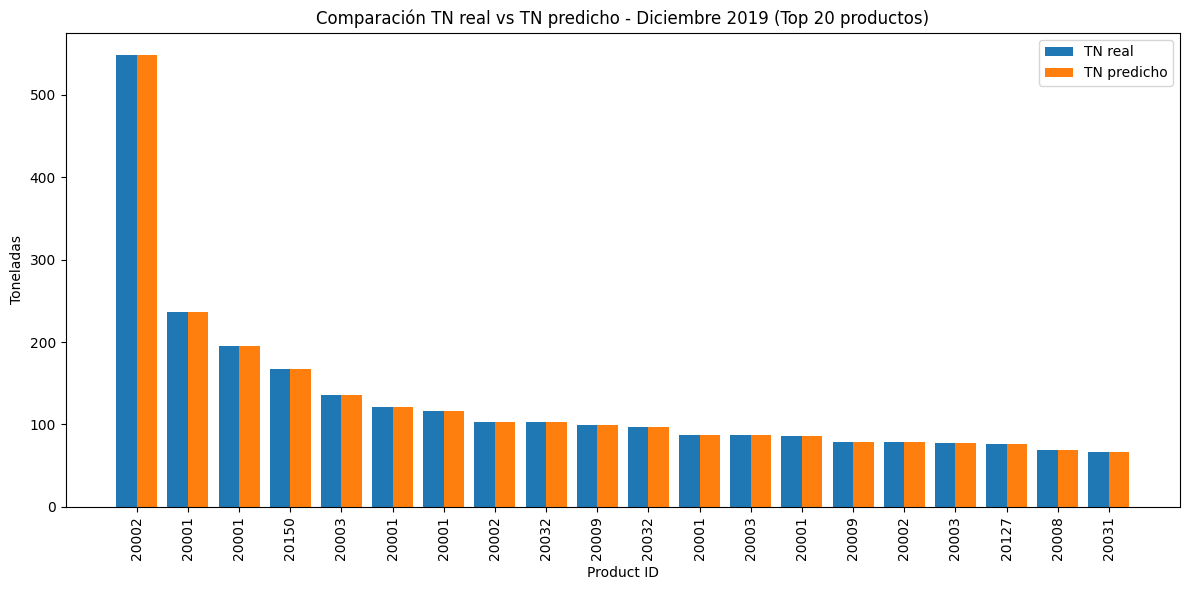

In [1]:
# 📦 Librerías necesarias
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Filtrar hasta noviembre 2019 para entrenamiento
df_train = df[df['periodo'] <= '2019-11-01'].copy()

# 3. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_train)
df_lags.dropna(inplace=True)

# 4. Calcular top 10 features correlacionadas con tn
correlaciones = df_lags.corr(numeric_only=True)['tn'].drop('tn').abs()
top_features = correlaciones.sort_values(ascending=False).head(10).index.tolist()

# 5. Separar train (hasta oct-2019) y test (nov-2019)
train_data = df_lags[df_lags['periodo'] < '2019-11-01']
test_data = df_lags[df_lags['periodo'] == '2019-11-01']

X_train = train_data[top_features]
y_train = train_data['tn']
X_test = test_data[top_features]
y_test = test_data['tn']

# 6. Entrenar modelo
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 7. Calcular MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"\n📉 MAE de regresión lineal simple para diciembre 2019: {mae:.4f}")

# 8. Agregar predicciones a test_data
test_data = test_data.copy()
test_data['tn_pred'] = y_pred
test_data['tn_real'] = y_test

# 9. Mostrar algunas predicciones
print("\n🔍 Ejemplos:")
print(test_data[['product_id', 'tn_pred', 'tn_real']].head())

# 10. Gráfico comparativo (Top 20 productos más vendidos)
df_plot = test_data.sort_values('tn_real', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(df_plot))

plt.bar(x - bar_width/2, df_plot['tn_real'], width=bar_width, label='TN real')
plt.bar(x + bar_width/2, df_plot['tn_pred'], width=bar_width, label='TN predicho')
plt.xticks(x, df_plot['product_id'], rotation=90)
plt.xlabel('Product ID')
plt.ylabel('Toneladas')
plt.title('Comparación TN real vs TN predicho - Diciembre 2019 (Top 20 productos)')
plt.legend()
plt.tight_layout()
plt.show()

# 11. Guardar archivo
test_data[['product_id', 'tn_pred', 'tn_real']].to_csv("predicciones_diciembre_regresion_lineal.csv", index=False)


C:\Users\waldo\AppData\Local\Temp\ipykernel_14684\1713245999.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_nov_diciembre = df[df['periodo'].isin(['2019-10-01', '2019-11-01'])].copy()



📉 MAE de regresión lineal simple para diciembre 2019: 2.2507

🔍 Ejemplos:
   product_id    tn_pred    tn_real
0       20001  236.65556  180.21938
1       20002  547.87849  334.03714
2       20003  135.69192  137.98717
3       20004   27.58851   12.94020
4       20005   11.01719    7.66693


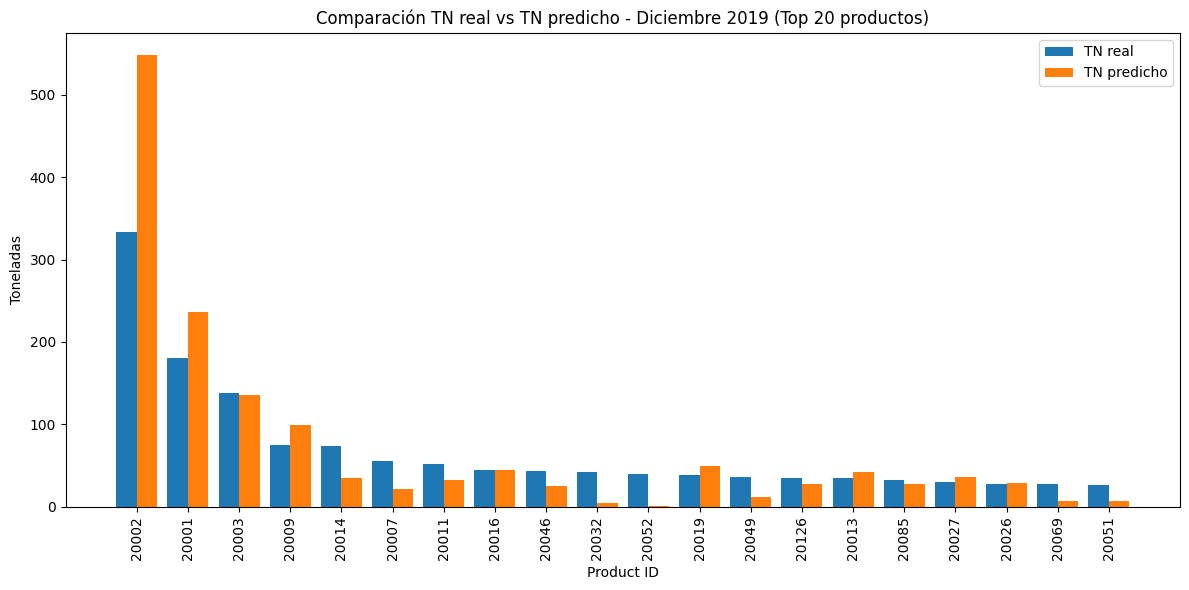

In [3]:
# 📦 Librerías necesarias
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Entrenar hasta octubre 2019
df_train = df[df['periodo'] <= '2019-10-01'].copy()

# 3. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

# 4. Crear lags en el set de entrenamiento
df_lags = crear_lags(df_train)
df_lags.dropna(inplace=True)

# 5. Top 10 features correlacionadas
correlaciones = df_lags.corr(numeric_only=True)['tn'].drop('tn').abs()
top_features = correlaciones.sort_values(ascending=False).head(10).index.tolist()

# 6. Entrenar modelo con datos hasta octubre 2019
X_train = df_lags[top_features]
y_train = df_lags['tn']
model = LinearRegression()
model.fit(X_train, y_train)

# 7. Generar lags en datos de nov y oct para predecir diciembre
df_nov_diciembre = df[df['periodo'].isin(['2019-10-01', '2019-11-01'])].copy()
df_pred_lags = crear_lags(df_nov_diciembre)
df_test = df_pred_lags[df_pred_lags['periodo'] == '2019-11-01'].copy()

# 8. Predecir diciembre 2019 (usando lags de nov)
X_test = df_test[top_features]
df_test['tn_pred'] = model.predict(X_test)

# 9. Comparar contra valores reales de diciembre 2019 (sin explotar memoria)
df_real = df[df['periodo'] == '2019-12-01'][['product_id', 'tn']].drop_duplicates('product_id').rename(columns={'tn': 'tn_real'})
df_test = df_test[['product_id', 'tn_pred']].drop_duplicates('product_id')
df_test = df_test.merge(df_real, on='product_id', how='inner')


# 10. Calcular MAE
mae = mean_absolute_error(df_test['tn_real'], df_test['tn_pred'])
print(f"\n📉 MAE de regresión lineal simple para diciembre 2019: {mae:.4f}")

# 11. Mostrar ejemplos
print("\n🔍 Ejemplos:")
print(df_test[['product_id', 'tn_pred', 'tn_real']].head())

# 12. Gráfico comparativo (Top 20 productos con mayor tn_real)
df_plot = df_test.sort_values('tn_real', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(df_plot))

plt.bar(x - bar_width/2, df_plot['tn_real'], width=bar_width, label='TN real')
plt.bar(x + bar_width/2, df_plot['tn_pred'], width=bar_width, label='TN predicho')
plt.xticks(x, df_plot['product_id'], rotation=90)
plt.xlabel('Product ID')
plt.ylabel('Toneladas')
plt.title('Comparación TN real vs TN predicho - Diciembre 2019 (Top 20 productos)')
plt.legend()
plt.tight_layout()
plt.show()

# 13. Guardar predicciones
df_test[['product_id', 'tn_pred', 'tn_real']].to_csv("predicciones_diciembre_regresion_lineal_sin_leak.csv", index=False)


C:\Users\waldo\AppData\Local\Temp\ipykernel_11188\493987314.py:46: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_input = df[df['periodo'].isin(['2019-10-01', '2019-11-01'])].copy()



📉 MAE con XGBoost para diciembre 2019: 2.2166

🔍 Ejemplos:
   product_id     tn_pred    tn_real
0       20001   74.200279  180.21938
1       20002  223.200302  334.03714
2       20003  111.350555  137.98717
3       20004   38.772701   12.94020
4       20005   13.110496    7.66693


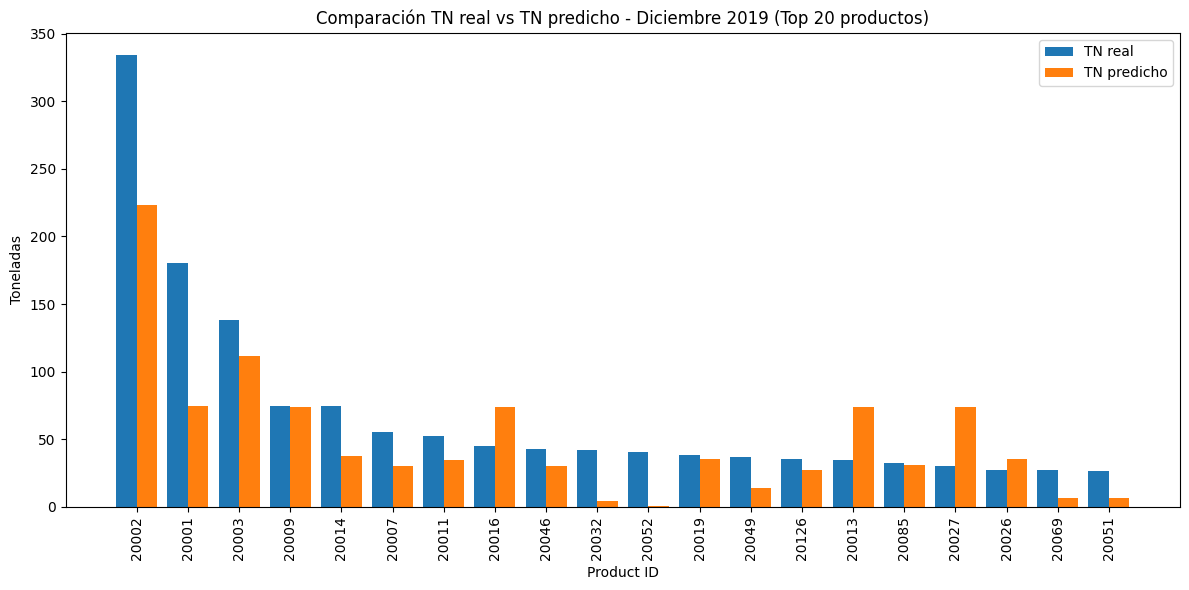

In [2]:
# 📦 Librerías necesarias
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Filtrar datos hasta octubre 2019 para entrenar
df_train = df[df['periodo'] <= '2019-10-01'].copy()

# 3. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

# 4. Crear lags sobre entrenamiento
df_lags = crear_lags(df_train)
df_lags.dropna(inplace=True)

# 5. Selección de top 10 features más correlacionadas con tn
correlaciones = df_lags.corr(numeric_only=True)['tn'].drop('tn').abs()
top_features = correlaciones.sort_values(ascending=False).head(10).index.tolist()

# 6. Entrenamiento con XGBoost
X_train = df_lags[top_features]
y_train = df_lags['tn']

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# 7. Preparar datos para predecir diciembre (usando lags de noviembre)
df_input = df[df['periodo'].isin(['2019-10-01', '2019-11-01'])].copy()
df_test_lags = crear_lags(df_input)
df_test = df_test_lags[df_test_lags['periodo'] == '2019-11-01'].copy()

# 8. Predecir
X_test = df_test[top_features]
df_test = df_test.copy()
df_test['tn_pred'] = model.predict(X_test)

# 9. Comparar con valores reales de diciembre
df_real = df[df['periodo'] == '2019-12-01'][['product_id', 'tn']].drop_duplicates('product_id').rename(columns={'tn': 'tn_real'})
df_test = df_test[['product_id', 'tn_pred']].drop_duplicates('product_id')
df_test = df_test.merge(df_real, on='product_id', how='inner')

# 10. Calcular MAE
mae = mean_absolute_error(df_test['tn_real'], df_test['tn_pred'])
print(f"\n📉 MAE con XGBoost para diciembre 2019: {mae:.4f}")

# 11. Mostrar ejemplos
print("\n🔍 Ejemplos:")
print(df_test[['product_id', 'tn_pred', 'tn_real']].head())

# 12. Gráfico comparativo (Top 20 productos con mayor venta)
df_plot = df_test.sort_values('tn_real', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(df_plot))

plt.bar(x - bar_width/2, df_plot['tn_real'], width=bar_width, label='TN real')
plt.bar(x + bar_width/2, df_plot['tn_pred'], width=bar_width, label='TN predicho')
plt.xticks(x, df_plot['product_id'], rotation=90)
plt.xlabel('Product ID')
plt.ylabel('Toneladas')
plt.title('Comparación TN real vs TN predicho - Diciembre 2019 (Top 20 productos)')
plt.legend()
plt.tight_layout()
plt.show()

# 13. Guardar archivo
df_test[['product_id', 'tn_pred', 'tn_real']].to_csv("predicciones_diciembre_xgboost.csv", index=False)


C:\Users\waldo\AppData\Local\Temp\ipykernel_11188\2996965488.py:52: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_input = df[df['periodo'].isin(['2019-10-01', '2019-11-01'])].copy()



📉 MAE con XGBoost + nuevas features para diciembre 2019: 3.2861

🔍 Ejemplos:
   product_id   tn_pred    tn_real
0       20001  0.031707  180.21938
1       20002  0.031707  334.03714
2       20003  0.031707  137.98717
3       20004  0.031707   12.94020
4       20005  0.031707    7.66693


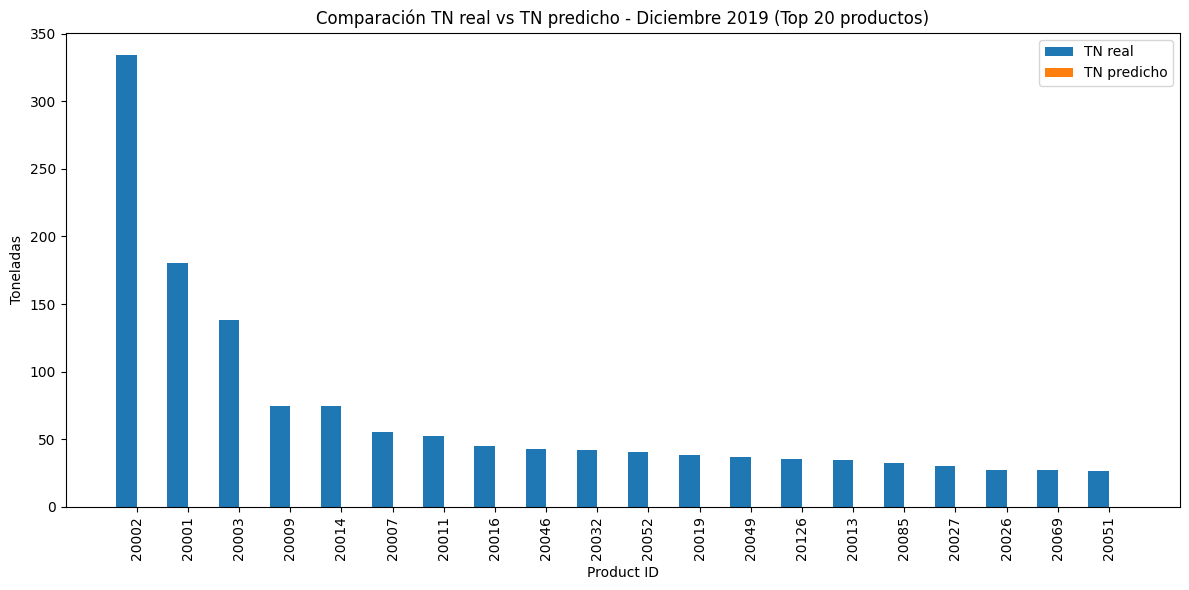

In [3]:
# 📦 Librerías necesarias
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Crear features temporales
df['mes'] = df['periodo'].dt.month
df['anio'] = df['periodo'].dt.year

# 3. Filtrar para entrenar hasta octubre 2019
df_train = df[df['periodo'] <= '2019-10-01'].copy()

# 4. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_train)
df_lags.dropna(inplace=True)

# 5. Crear nuevas features a partir de lags
df_lags['lag_diff'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['lag_ratio'] = df_lags['lag_1'] / (df_lags['lag_2'] + 1e-5)

# 6. Definir features a usar
feature_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_diff', 'lag_ratio', 'mes', 'anio']

# 7. Entrenar modelo
X_train = df_lags[feature_cols]
y_train = df_lags['tn']

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# 8. Preparar datos para predecir diciembre
df_input = df[df['periodo'].isin(['2019-10-01', '2019-11-01'])].copy()
df_input['mes'] = df_input['periodo'].dt.month
df_input['anio'] = df_input['periodo'].dt.year
df_test_lags = crear_lags(df_input)
df_test = df_test_lags[df_test_lags['periodo'] == '2019-11-01'].copy()

# 9. Agregar nuevas features en test
df_test['lag_diff'] = df_test['lag_1'] - df_test['lag_2']
df_test['lag_ratio'] = df_test['lag_1'] / (df_test['lag_2'] + 1e-5)

X_test = df_test[feature_cols]
df_test = df_test.copy()
df_test['tn_pred'] = model.predict(X_test)

# 10. Comparar con valores reales de diciembre
df_real = df[df['periodo'] == '2019-12-01'][['product_id', 'tn']].drop_duplicates('product_id').rename(columns={'tn': 'tn_real'})
df_test = df_test[['product_id', 'tn_pred']].drop_duplicates('product_id')
df_test = df_test.merge(df_real, on='product_id', how='inner')

# 11. MAE
mae = mean_absolute_error(df_test['tn_real'], df_test['tn_pred'])
print(f"\n📉 MAE con XGBoost + nuevas features para diciembre 2019: {mae:.4f}")

# 12. Ejemplos
print("\n🔍 Ejemplos:")
print(df_test[['product_id', 'tn_pred', 'tn_real']].head())

# 13. Gráfico comparativo
df_plot = df_test.sort_values('tn_real', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(df_plot))

plt.bar(x - bar_width/2, df_plot['tn_real'], width=bar_width, label='TN real')
plt.bar(x + bar_width/2, df_plot['tn_pred'], width=bar_width, label='TN predicho')
plt.xticks(x, df_plot['product_id'], rotation=90)
plt.xlabel('Product ID')
plt.ylabel('Toneladas')
plt.title('Comparación TN real vs TN predicho - Diciembre 2019 (Top 20 productos)')
plt.legend()
plt.tight_layout()
plt.show()

# 14. Guardar resultados
df_test[['product_id', 'tn_pred', 'tn_real']].to_csv("predicciones_diciembre_xgboost_mejorado.csv", index=False)
